In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

dataset = pd.read_csv('World Energy Consumption.csv')

# Check the dataset's structure
dataset.head()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,ASEAN (Ember),2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,ASEAN (Ember),2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2,ASEAN (Ember),2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
3,ASEAN (Ember),2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
4,ASEAN (Ember),2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN


In [2]:
critical_columns = [
    'country','year','population','gdp','coal_production','electricity_generation',
    'biofuel_electricity','coal_electricity','fossil_electricity','gas_electricity',
    'hydro_electricity','nuclear_electricity','oil_electricity','renewables_electricity',
    'oil_production','solar_electricity','wind_electricity','energy_per_gdp',
    'energy_per_capita','fossil_share_elec','gas_share_elec',
    'low_carbon_share_elec','gas_electricity','biofuel_consumption','coal_consumption',
    'gas_consumption','hydro_consumption','nuclear_consumption',
    'oil_consumption','solar_consumption','wind_consumption'
]
# Extract relevant columns
energy_data = dataset[critical_columns].copy()

# Filter by year and countries of interest
energy_data = energy_data[energy_data['year'] >= 1985]

# Filter by top countries in the World
Countries = [
    'China','India','United States','Japan','USSR/Russia','Germany',
    'Italy','United Kingdom','France','Canada'
]

# Unify naming for USSR/Russia and United States variants
energy_data['country'] = energy_data['country'].replace({
    'USSR':'USSR/Russia', 
    'Russia': 'USSR/Russia',
    'United States Territories (Shift)':'United States', 
    'United States Virgin Islands': 'United States',
    'United States Pacific Islands (Shift)': 'United States'
})

# Keep only the chosen countries
energy_data = energy_data.loc[energy_data['country'].isin(Countries)]

# Remove duplicate columns if any
energy_data = energy_data.loc[:, ~energy_data.columns.duplicated()]

# Check for missing values
missing_values = energy_data.isna().sum()
print(missing_values)


country                     0
year                        0
population                 93
gdp                       143
coal_production            46
electricity_generation    115
biofuel_electricity       225
coal_electricity          115
fossil_electricity        115
gas_electricity           115
hydro_electricity         115
nuclear_electricity       115
oil_electricity           115
renewables_electricity    126
oil_production             52
solar_electricity         135
wind_electricity          126
energy_per_gdp            170
energy_per_capita          93
fossil_share_elec         115
gas_share_elec            115
low_carbon_share_elec     115
biofuel_consumption       276
coal_consumption          137
gas_consumption           137
hydro_consumption         137
nuclear_consumption       142
oil_consumption           137
solar_consumption         157
wind_consumption          148
dtype: int64


In [5]:
numeric_cols = energy_data.select_dtypes(include=[np.number]).columns
categorical_cols = energy_data.select_dtypes(exclude=[np.number]).columns

# For categorical data (like country), forward fill might make sense if data is time-series:
# Sort by country and year before forward/backward filling to ensure time order is respected
energy_data = energy_data.sort_values(by=['country', 'year'])

# Forward fill followed by backward fill for categorical columns
# ensures no gaps remain if data is fully contained.

for col in categorical_cols:
    if energy_data[col].isna().any():
        energy_data[col] = energy_data[col].ffill().bfill()

# For numeric columns, consider interpolation if the data is time-series:
# Interpolation might be better than just ffill/bfill for numeric, time-series data
# We'll do a group-wise interpolation by country, as it makes sense that missing data
# should be interpolated based on the same country
# If still missing, fallback to ffill/bfill

for col in numeric_cols:
    if energy_data[col].isna().any():
        energy_data[col] = energy_data.groupby('country')[col].transform(lambda group: group.interpolate(method='linear'))
        energy_data[col] = energy_data.groupby('country')[col].ffill().bfill()
# Re-check missing values
print("Missing values per column after cleaning:\n", energy_data.isna().sum())

Missing values per column after cleaning:
 country                   0
year                      0
population                0
gdp                       0
coal_production           0
electricity_generation    0
biofuel_electricity       0
coal_electricity          0
fossil_electricity        0
gas_electricity           0
hydro_electricity         0
nuclear_electricity       0
oil_electricity           0
renewables_electricity    0
oil_production            0
solar_electricity         0
wind_electricity          0
energy_per_gdp            0
energy_per_capita         0
fossil_share_elec         0
gas_share_elec            0
low_carbon_share_elec     0
biofuel_consumption       0
coal_consumption          0
gas_consumption           0
hydro_consumption         0
nuclear_consumption       0
oil_consumption           0
solar_consumption         0
wind_consumption          0
dtype: int64


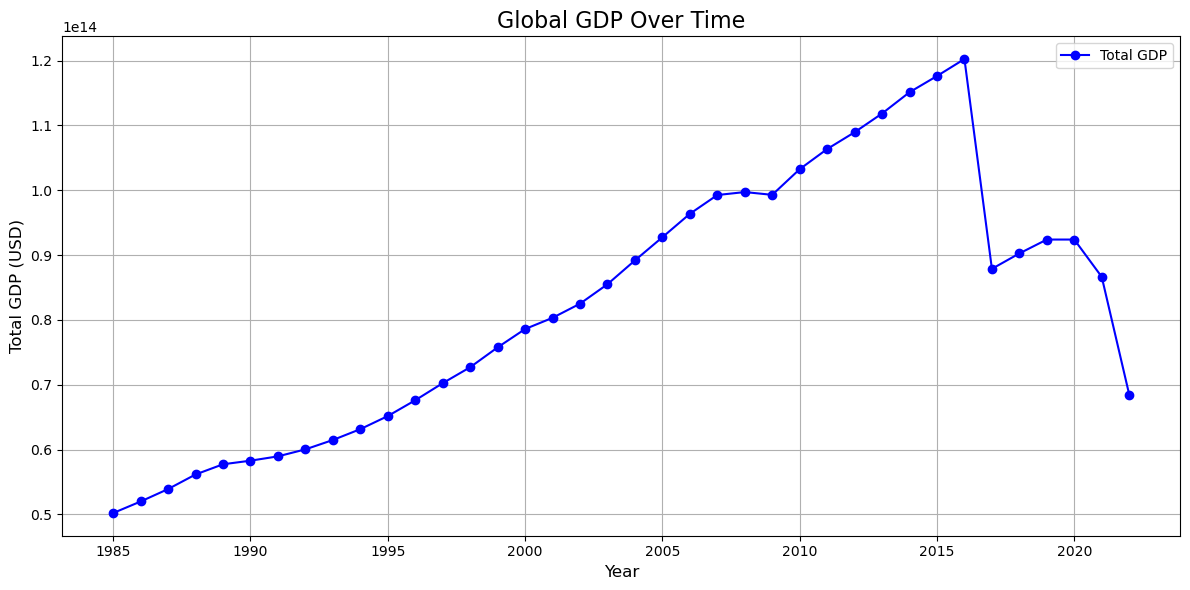

In [7]:
# Group data by year and sum GDP
gdp_by_year = energy_data.groupby('year')['gdp'].sum()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(gdp_by_year.index, gdp_by_year.values, marker='o', linestyle='-', color='blue', label='Total GDP')

# Add labels and title
plt.title('Global GDP Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total GDP (USD)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

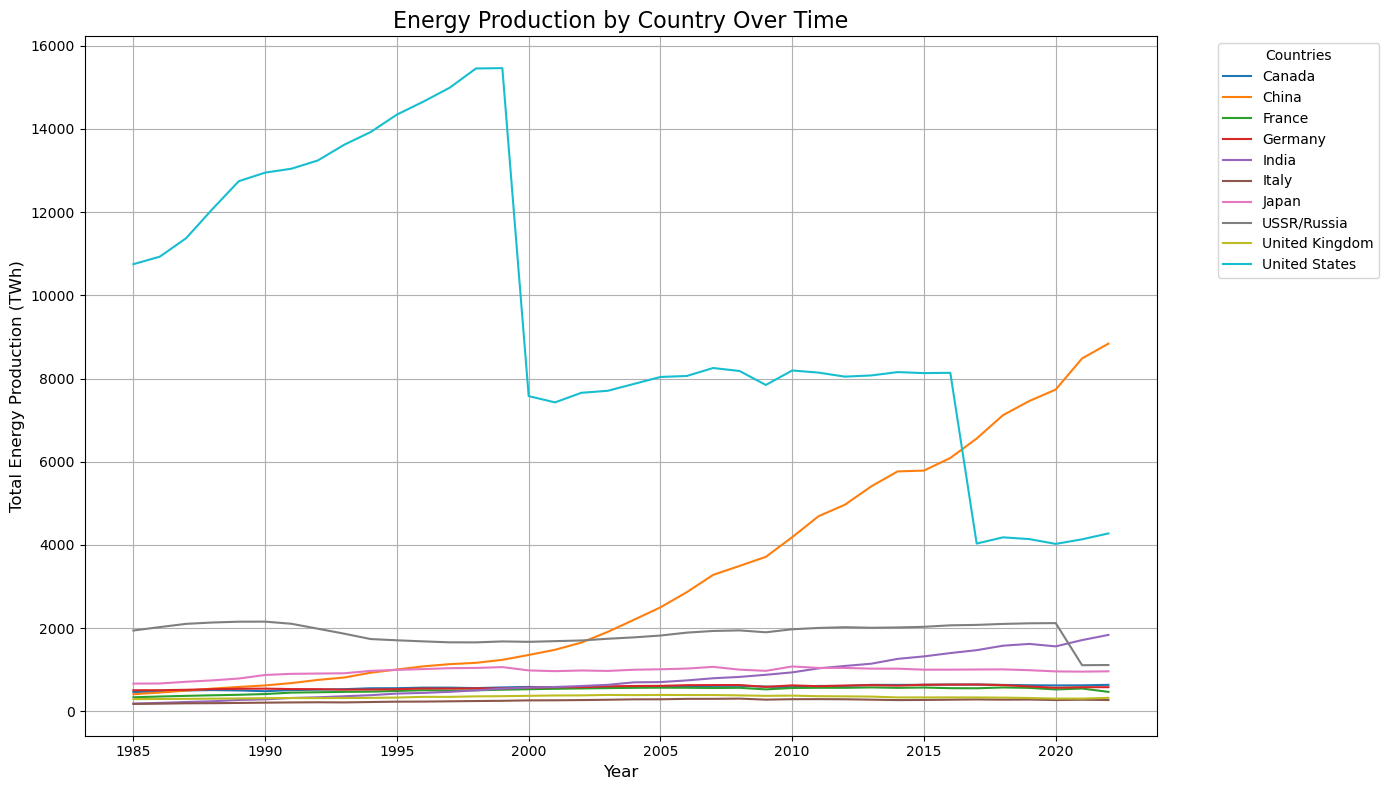

In [9]:
# Calculate total energy production for each country and year
renewable_energy= ['biofuel_electricity','hydro_electricity','solar_electricity',
                    'wind_electricity']
nonrenewable_energy =['oil_electricity','coal_electricity','gas_electricity','nuclear_electricity']

all_sources = renewable_energy + nonrenewable_energy
energy_data['total_energy_production'] = energy_data[all_sources].sum(axis=1)

# Group by country and year
country_year_production = energy_data.groupby(['country', 'year'])['total_energy_production'].sum().unstack('country')

# Plot the trends
plt.figure(figsize=(14, 8))
for country in country_year_production.columns:
    plt.plot(country_year_production.index, country_year_production[country], label=country)

# Add labels and title
plt.title('Energy Production by Country Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Energy Production (TWh)', fontsize=12)
plt.grid(True)
plt.legend(title="Countries", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

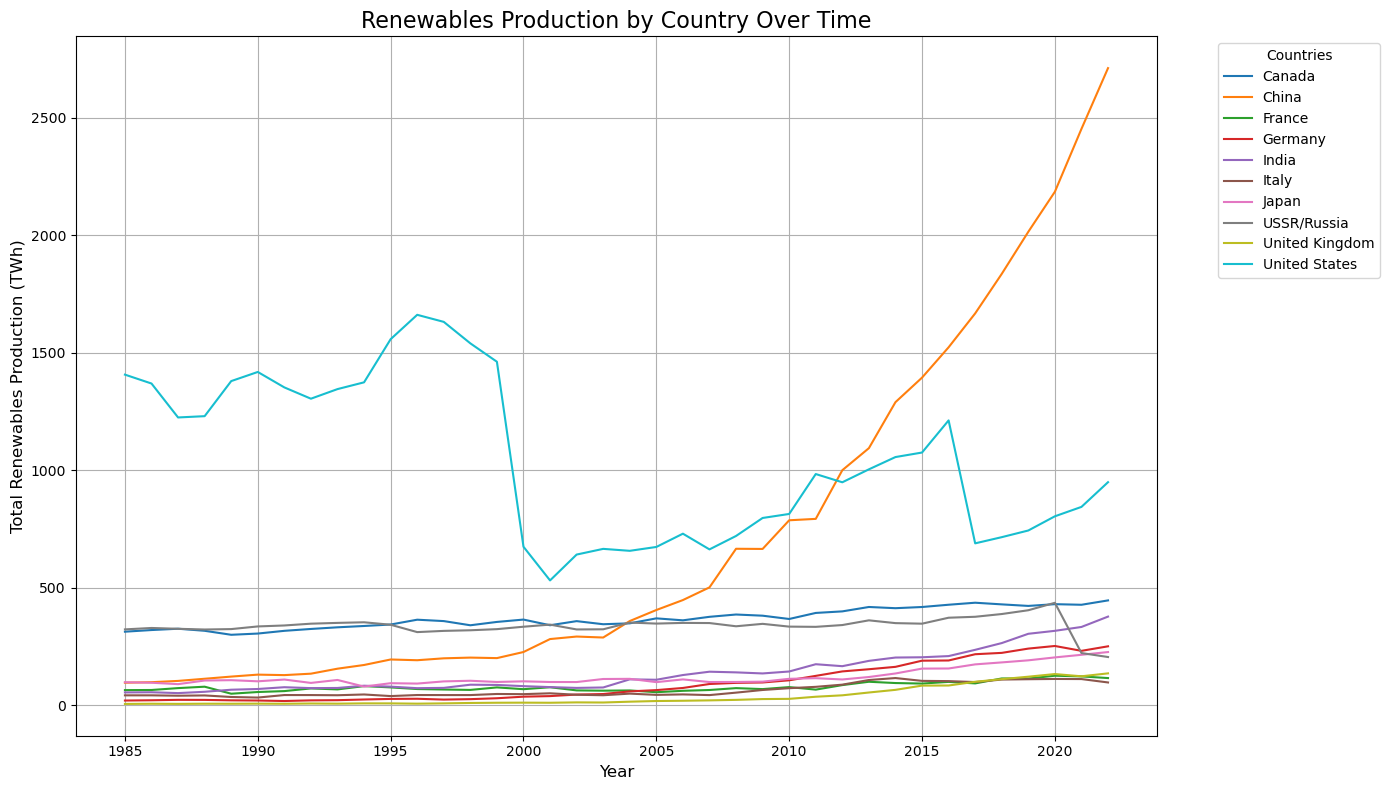

In [11]:

# Calculate renewables for each country and year
energy_data['renewables_production'] = energy_data[renewable_energy].sum(axis=1)

# Group by country and year
country_year_renewables = energy_data.groupby(['country', 'year'])['renewables_production'].sum().unstack('country')

# Plot the trends
plt.figure(figsize=(14, 8))
for country in country_year_renewables.columns:
    plt.plot(country_year_renewables.index, country_year_renewables[country], label=country)

# Add labels and title
plt.title('Renewables Production by Country Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Renewables Production (TWh)', fontsize=12)
plt.grid(True)
plt.legend(title="Countries", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()                

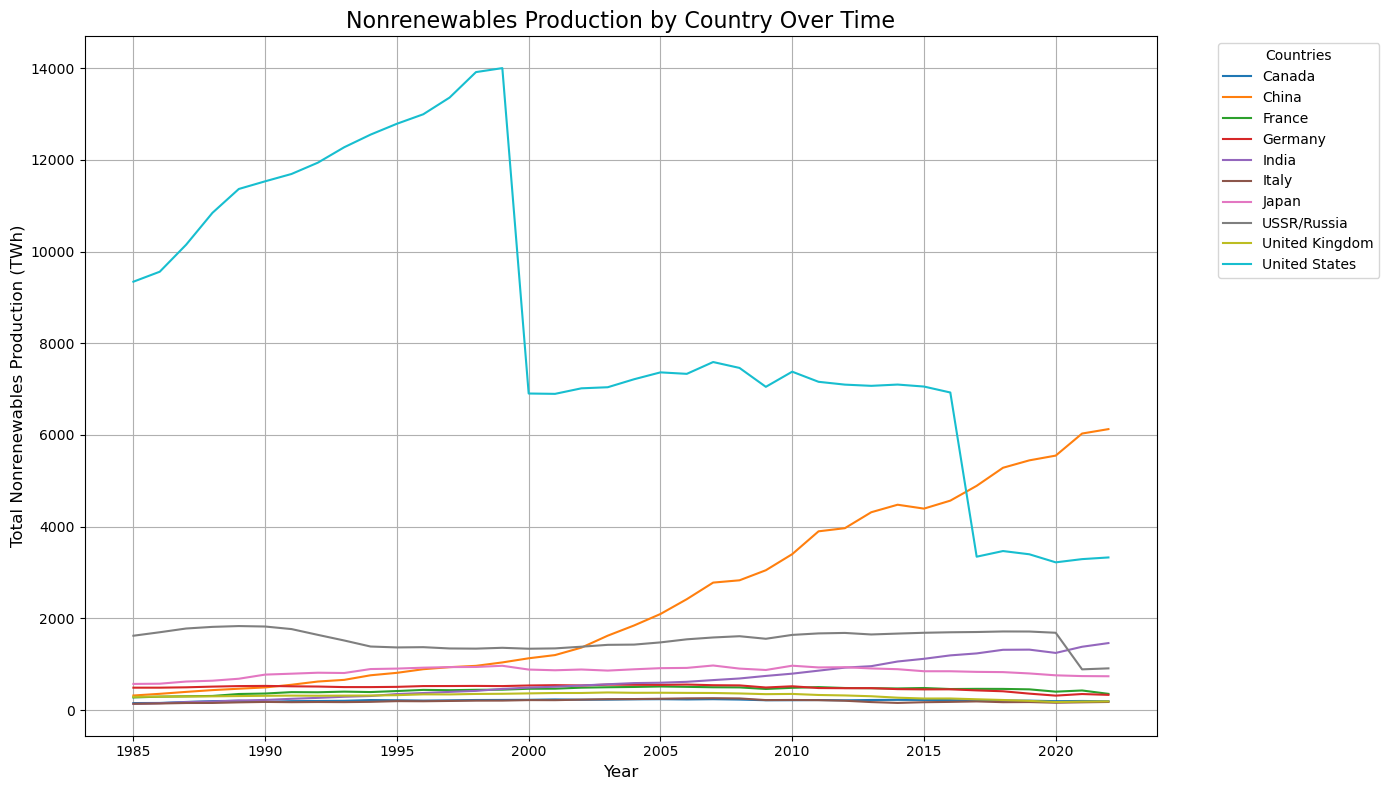

In [13]:
# Calculate nonrenewable for each country and year
energy_data['nonrenewables_production'] = energy_data[nonrenewable_energy].sum(axis=1)

# Group by country and year
country_year_nonrenewables = energy_data.groupby(['country', 'year'])['nonrenewables_production'].sum().unstack('country')

# Plot the trends
plt.figure(figsize=(14, 8))
for country in country_year_nonrenewables.columns:
    plt.plot(country_year_nonrenewables.index, country_year_nonrenewables[country], label=country)

# Add labels and title
plt.title('Nonrenewables Production by Country Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Nonrenewables Production (TWh)', fontsize=12)
plt.grid(True)
plt.legend(title="Countries", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

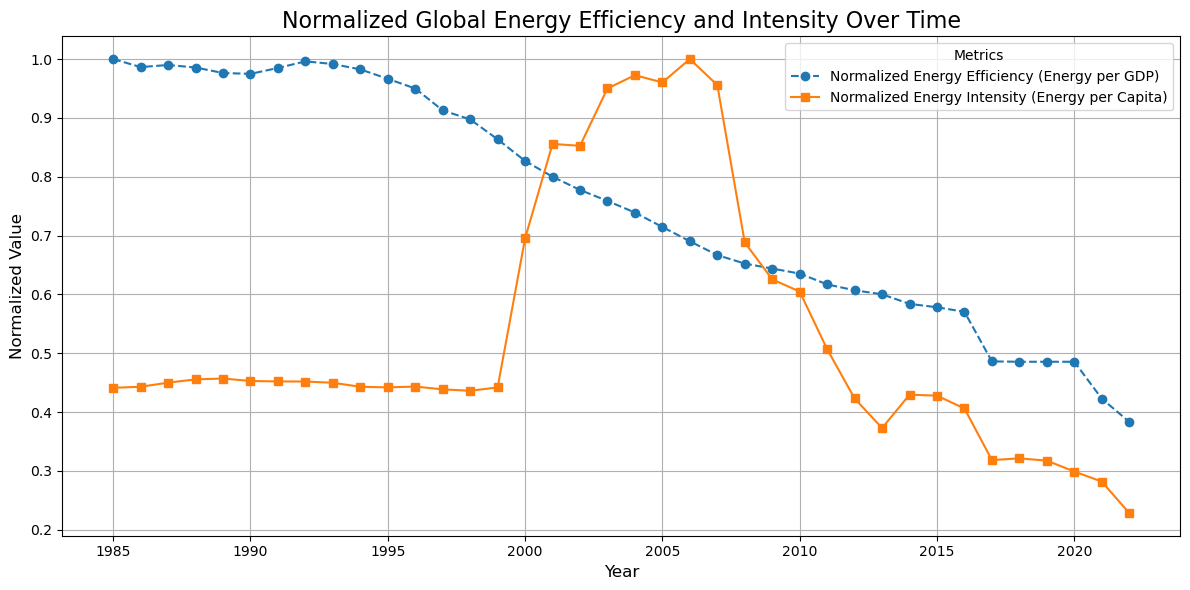

In [15]:
# Normalize both columns
efficiency_intensity = energy_data.groupby('year')[['energy_per_gdp', 'energy_per_capita']].sum()

efficiency_intensity['normalized_energy_per_gdp'] = efficiency_intensity['energy_per_gdp'] / efficiency_intensity['energy_per_gdp'].max()
efficiency_intensity['normalized_energy_per_capita'] = efficiency_intensity['energy_per_capita'] / efficiency_intensity['energy_per_capita'].max()

# Plot normalized data
plt.figure(figsize=(12, 6))
plt.plot(efficiency_intensity.index, efficiency_intensity['normalized_energy_per_gdp'], label='Normalized Energy Efficiency (Energy per GDP)', marker='o', linestyle='--')
plt.plot(efficiency_intensity.index, efficiency_intensity['normalized_energy_per_capita'], label='Normalized Energy Intensity (Energy per Capita)', marker='s', linestyle='-')
plt.title('Normalized Global Energy Efficiency and Intensity Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend(title="Metrics")
plt.grid(True)
plt.tight_layout()
plt.show()


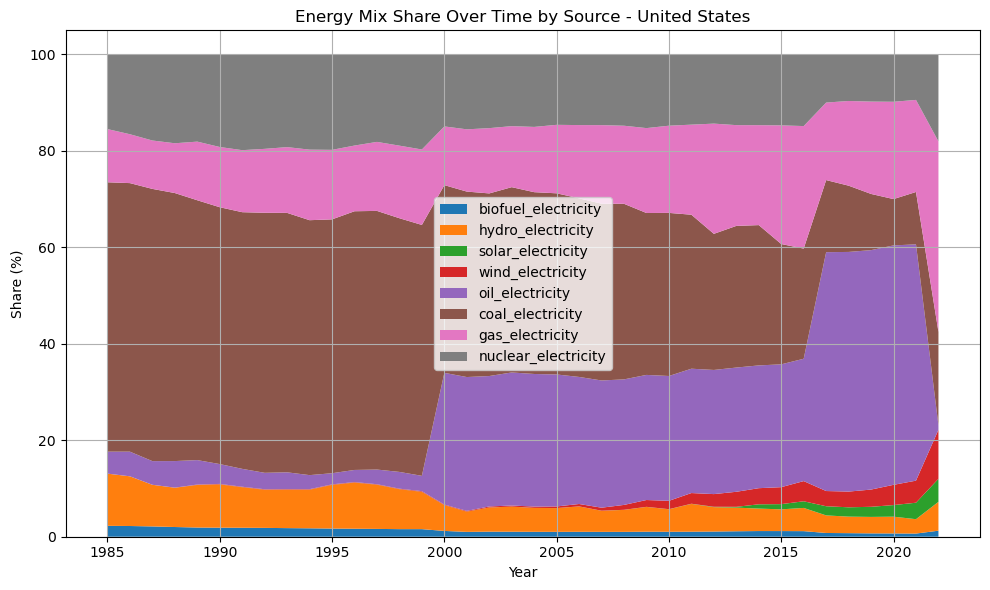

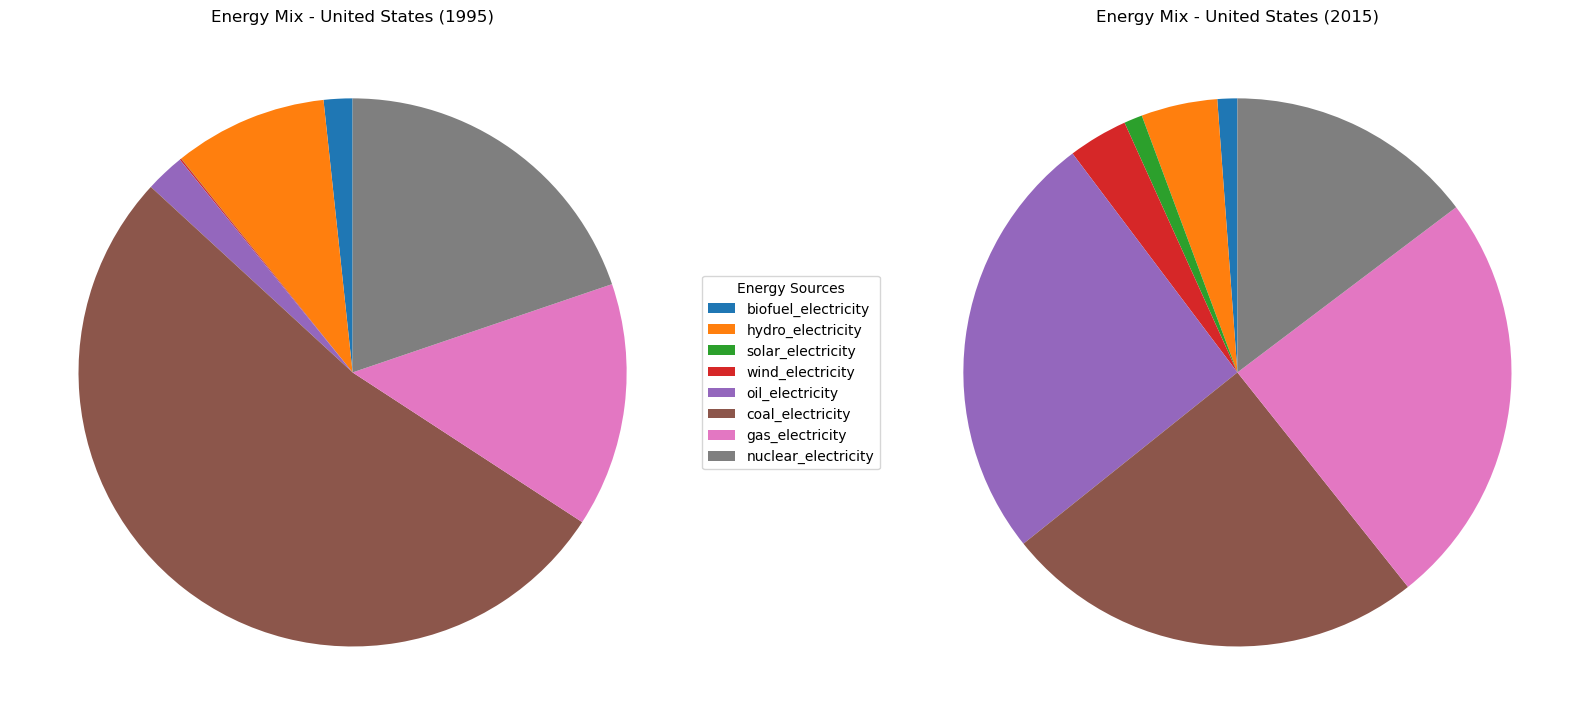

In [17]:
# Calculate individual source shares
for source in all_sources:
    energy_data[source + '_share'] = (energy_data[source] / energy_data['total_energy_production']) * 100

# Group by country and year to get the average shares
source_shares = energy_data.groupby(['country', 'year'])[[src + '_share' for src in all_sources]].mean()

# Choose a country to visualize
country_choice = 'United States'

# Extract that country's data and ensure it's sorted by year
country_source_shares = source_shares.xs(country_choice, level='country').sort_index()

# Prepare data for stackplot: 
# stackplot expects each energy source series as a separate array in the correct order
stack_data = [country_source_shares[src + '_share'] for src in all_sources]

# Plot the stacked area chart
plt.figure(figsize=(10, 6))
plt.stackplot(country_source_shares.index, stack_data, labels=all_sources)

plt.title(f'Energy Mix Share Over Time by Source - {country_choice}')
plt.xlabel('Year')
plt.ylabel('Share (%)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show

year1 = 1995
year2 = 2015

# Extract the data for each year
# Make sure these years exist in your dataset for the chosen country
data_year1 = country_source_shares.loc[year1, [src + '_share' for src in all_sources]]
data_year2 = country_source_shares.loc[year2, [src + '_share' for src in all_sources]]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Pie chart for year1
axes[0].pie(data_year1, startangle=90)
axes[0].set_title(f'Energy Mix - {country_choice} ({year1})')


# Pie chart for year2
axes[1].pie(data_year2,  startangle=90)
axes[1].set_title(f'Energy Mix - {country_choice} ({year2})')

# Add a legend outside the pie chart
axes[0].legend( all_sources, title="Energy Sources", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()


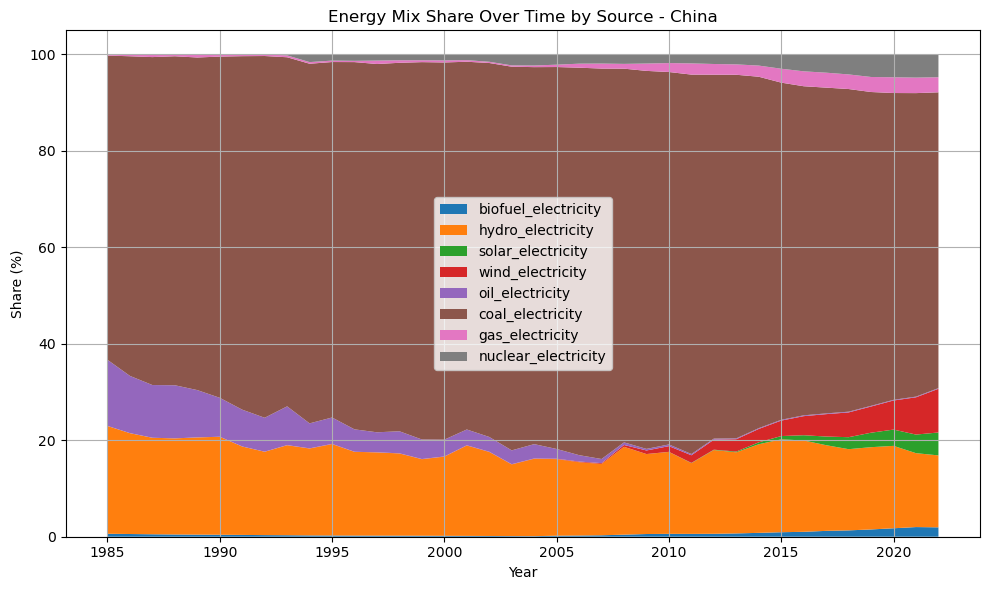

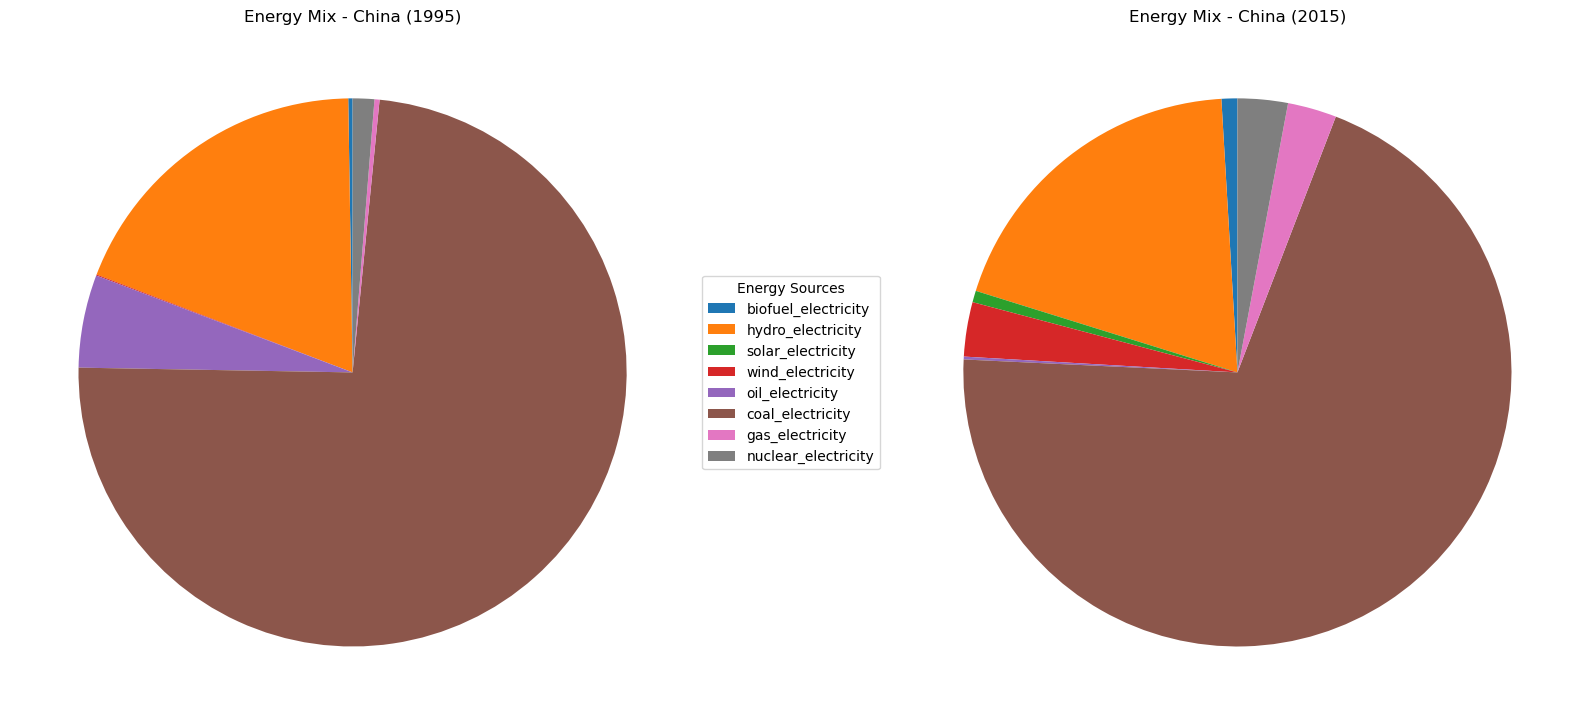

In [19]:

# Calculate individual source shares
for source in all_sources:
    energy_data[source + '_share'] = (energy_data[source] / energy_data['total_energy_production']) * 100

# Group by country and year to get the average shares
source_shares = energy_data.groupby(['country', 'year'])[[src + '_share' for src in all_sources]].mean()

# Choose a country to visualize
country_choice = 'China'

# Extract that country's data and ensure it's sorted by year
country_source_shares = source_shares.xs(country_choice, level='country').sort_index()

# Prepare data for stackplot: 
# stackplot expects each energy source series as a separate array in the correct order
stack_data = [country_source_shares[src + '_share'] for src in all_sources]

# Plot the stacked area chart
plt.figure(figsize=(10, 6))
plt.stackplot(country_source_shares.index, stack_data, labels=all_sources)

plt.title(f'Energy Mix Share Over Time by Source - {country_choice}')
plt.xlabel('Year')
plt.ylabel('Share (%)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

year1 = 1995
year2 = 2015

# Extract the data for each year
# Make sure these years exist in your dataset for the chosen country
data_year1 = country_source_shares.loc[year1, [src + '_share' for src in all_sources]]
data_year2 = country_source_shares.loc[year2, [src + '_share' for src in all_sources]]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Pie chart for year1
axes[0].pie(data_year1, startangle=90)
axes[0].set_title(f'Energy Mix - {country_choice} ({year1})')


# Pie chart for year2
axes[1].pie(data_year2, startangle=90)
axes[1].set_title(f'Energy Mix - {country_choice} ({year2})')


# Add a legend outside the pie chart
axes[0].legend(all_sources, title="Energy Sources", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()


In [21]:
y = (energy_data['gdp'])
X = energy_data[[
    'gas_electricity',
    'oil_electricity',
    'nuclear_electricity',
    'hydro_electricity',
    'solar_electricity',
    'coal_electricity'
]]
# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the OLS (Ordinary Least Squares) regression model
model = sm.OLS(y, X).fit()

# Print the summary which includes coefficients and p-values
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     123.2
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           7.50e-96
Time:                        16:27:58   Log-Likelihood:                -15649.
No. Observations:                 517   AIC:                         3.131e+04
Df Residuals:                     510   BIC:                         3.134e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3.957e+12   2

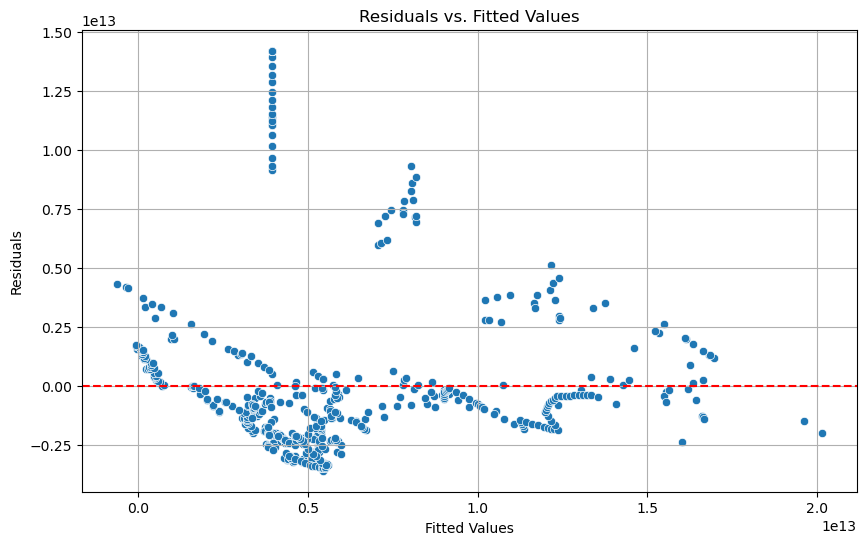

In [23]:
fitted_vals = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(10,6))
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

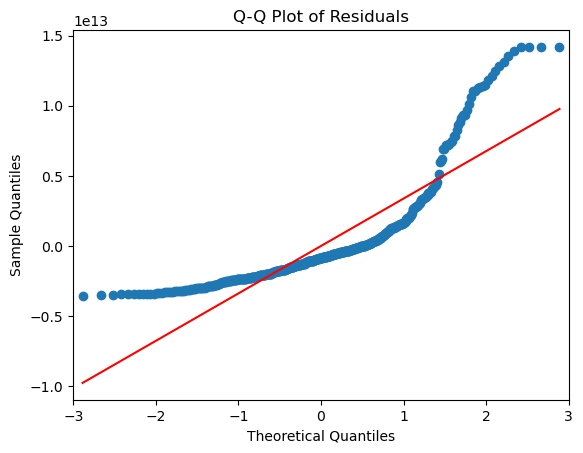

Durbin-Watson: 0.7958196175918787


In [25]:
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

dw = sm.stats.stattools.durbin_watson(residuals)
print("Durbin-Watson:", dw)

In [27]:
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("Variance Inflation Factors:\n", vif_data)


Variance Inflation Factors:
                Feature       VIF
0                const  3.125196
1      gas_electricity  2.051934
2      oil_electricity  1.228499
3  nuclear_electricity  2.796108
4    hydro_electricity  3.522358
5    solar_electricity  1.514125
6     coal_electricity  4.458434
